In [3]:
import numpy as np 
import pandas as pd


#file_path = '/kaggle/input/wasserstand-raw/pikobytesbafg5952025w.csv'
file_path = '/kaggle/input/wasserstand-raw/sensor2.csv'

# CSV Datei laden
df = pd.read_csv(file_path)

df['begin'] = pd.to_datetime(df['begin'])
df['timestamp']= df['begin']
df['wasserstand'] = df['v']
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
data = df[['year', 'month', 'day', 'hour', 'minute', 'wasserstand']]
numpy_array = data.to_numpy()
numpy_array_ohne_letzten_tag = numpy_array[:] #wichtig , da im letzten tag werte nie minütlich gelesen werden, also viele NULLs


data = numpy_array_ohne_letzten_tag
# Neue Liste, die die korrigierten Daten enthält
corrected_data = [data[0]]  # Die erste Zeile wird immer übernommen

# Schleife, um jede Minute zu überprüfen
for i in range(1, len(data)):
    prev_minute = data[i - 1][4]
    prev_value = data[i - 1][5]
    curr_minute = data[i][4]
    
    #berprüfung, ob die aktuelle Minute x+1 ist oder der Übergang von 59 auf 00 stattfindet
    while curr_minute != (prev_minute + 1) % 60:
        # Wenn eine Minute übersprungen wurde, fügen wir die fehlende Minute mit dem gleichen Wasserstand hinzu
        corrected_data.append(np.array([data[i-1][0], data[i-1][1], data[i-1][2], data[i-1][3], (prev_minute + 1) % 60, prev_value]))
        prev_minute = (prev_minute + 1) % 60  # Minuten wird um 1 erhöht
        
    
    # Füge die aktuelle Zeile hinzu
    corrected_data.append(data[i])

# Um Ergebnis zu sehen
corrected_data = np.array(corrected_data)


In [4]:
def convert_to_cyclic(arr):
    year = arr[:, 0]
    month = arr[:, 1]
    day = arr[:, 2]
    hour = arr[:, 3]
    minute = arr[:, 4]
    
    # Convert month to cyclic values
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    
    # Convert day to cyclic values
    day_sin = np.sin(2 * np.pi * day / 31)  # Assuming  31 days
    day_cos = np.cos(2 * np.pi * day / 31)
    
    # Convert hour to cyclic values
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    # Convert minute to cyclic values
    minute_sin = np.sin(2 * np.pi * minute / 60)
    minute_cos = np.cos(2 * np.pi * minute / 60)
    
    # Stack the transformed values
    transformed_array = np.column_stack((year, month_sin, month_cos, day_sin, day_cos, hour_sin, hour_cos, minute_sin, minute_cos))
    
    return transformed_array

corrected_data[:,0] -= 2000
b = corrected_data

corrected_data = corrected_data.astype(np.float16)
corrected_data[:,-1] /= 1000
corrected_data[:,0] /= 1000
b = corrected_data

b1 = convert_to_cyclic(b)
b2=b[:,-1]
print(b1.shape)
print(b2.shape)
b2 = b2.reshape((2938653, 1))
c = np.concatenate((b1,b2), axis=1)

(2938653, 9)
(2938653,)


In [5]:
print(c.shape)

(2938653, 10)


In [14]:
print(c.shape)

# Beispiel: DataFrame mit 6 Spalten (letzte Spalte = Wasserstand)
df = pd.DataFrame(c)  # your_data = dein Numpy-Array oder DataFrame
df.columns = ["col1", "col2", "col3", "col4", "col5", "col6","col7","col8","col9","water_level"]

# Zeiteinheiten in Minuten
minutes_per_day = 60 * 24 
minutes_per_week = minutes_per_day * 7 
minutes_per_month = minutes_per_day * 30

# Berechnung der Moving Averages
df["MA_Day"] = df["water_level"].rolling(window=minutes_per_day, min_periods=1).mean()
df["MA_Week"] = df["water_level"].rolling(window=minutes_per_week, min_periods=1).mean()
df["MA_Month"] = df["water_level"].rolling(window=minutes_per_month, min_periods=1).mean()

# Spalten neu anordnen (Moving Averages an den Anfang)
df = df[["MA_Month", "MA_Week", "MA_Day"] + df.columns[:-3].tolist()]


print(df.head())  # Ausgabe der ersten Zeilen
d = df.to_numpy()
print(d.shape)

(2938653, 10)
   MA_Month   MA_Week    MA_Day      col1      col2      col3     col4  \
0  0.480957  0.480957  0.480957  0.018997 -0.499023 -0.866699 -0.96875   
1  0.480469  0.480469  0.480469  0.018997 -0.499023 -0.866699 -0.96875   
2  0.480306  0.480306  0.480306  0.018997 -0.499023 -0.866699 -0.96875   
3  0.479980  0.479980  0.479980  0.018997 -0.499023 -0.866699 -0.96875   
4  0.479590  0.479590  0.479590  0.018997 -0.499023 -0.866699 -0.96875   

       col5      col6  col7      col8      col9  water_level  
0 -0.248779  0.000968  -1.0  0.000000  1.000000     0.480957  
1 -0.248779  0.000968  -1.0  0.104492  0.994629     0.479980  
2 -0.248779  0.000968  -1.0  0.207764  0.978027     0.479980  
3 -0.248779  0.000968  -1.0  0.308838  0.951172     0.479004  
4 -0.248779  0.000968  -1.0  0.406494  0.913574     0.478027  
(2938653, 13)


In [9]:
print(d.shape)
a = int(2938653*0.9)
b_test = d[a:]
b_train_val = d[:a]
print(b_test.shape)
print(b_train_val.shape)

np.savez_compressed('data_clean_2_compressed', d)

(2938653, 13)
(293866, 13)
(2644787, 13)


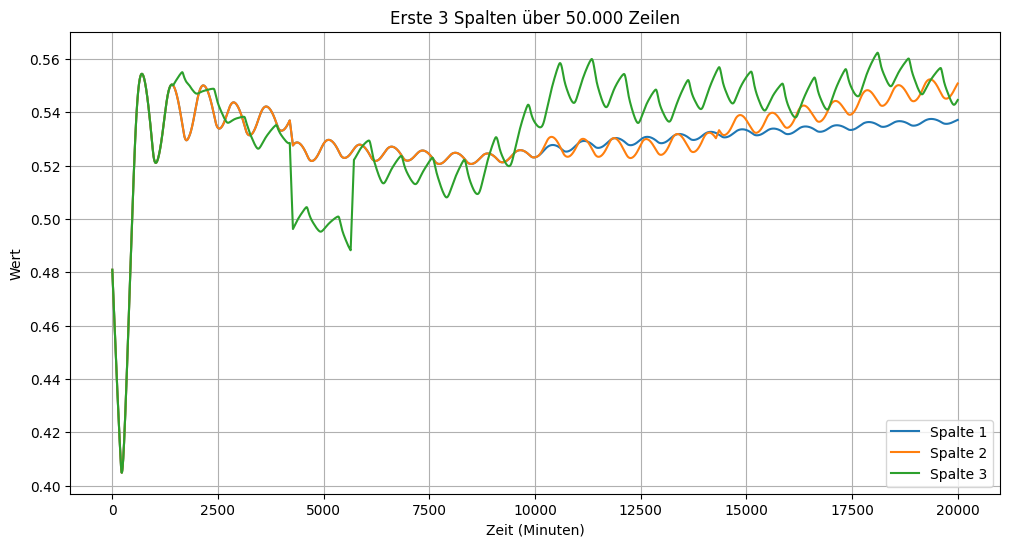

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Annahme: Dein NumPy-Array hat die Form (3951851, 16)
# Wähle die ersten 50.000 Zeilen und ersten 3 Spalten
data_subset = d[:20000, :3]

# Erstelle den Plot
plt.figure(figsize=(12, 6))

# Jede der 3 Spalten plotten
for i in range(3):
    plt.plot(data_subset[:, i], label=f"Spalte {i+1}")

# Achsenbeschriftungen & Legende
plt.xlabel("Zeit (Minuten)")
plt.ylabel("Wert")
plt.title("Erste 3 Spalten über 50.000 Zeilen")
plt.legend()
plt.grid(True)

plt.show()


In [18]:
import numpy as np

def create_train_data_generator(data, window_size, batch_size=100000):
    data = np.array(data, dtype=np.float16)  # Speicher sparen durch float32
    num_samples = data.shape[0] - window_size + 1  # Anzahl der Sliding Windows

    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)

        # Sliding Window nur für den aktuellen Batch berechnen
        windows = np.lib.stride_tricks.sliding_window_view(data[start:end + window_size - 1, 12], window_size)
        
        # Batch von Features + Sliding Window zurückgeben (yield für iterativen Ansatz)
        for i in range(len(windows)):  
            yield np.hstack((data[start + i, :12], windows[i]))

# Beispiel für Nutzung:
batch_size = 100000
window_size = 1500
data_clean_mit_zeit = []

for row in create_train_data_generator(d, window_size, batch_size):
    data_clean_mit_zeit.append(row)

# In NumPy-Array umwandeln
data_clean_mit_zeit = np.array(data_clean_mit_zeit, dtype=np.float16)
print(data_clean_mit_zeit.shape)  # Sollte eine speicherfreundliche Form haben


(2937154, 1512)


In [19]:
np.savez_compressed('1512_2_compressed', data_clean_mit_zeit)